# PA Quantum Neuron

Build a classical neuron with a quantum circuit

In [1]:
from colorama import Fore, Back, Style 

import numpy as np
import pennylane as qml
from pennylane.optimize import NesterovMomentumOptimizer
# from pennylane import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from math import pi


# Quantum

In [2]:

dev_1 = qml.device('default.qubit', wires=1)
dev_2 = qml.device('default.qubit', wires=1)
dev_3 = qml.device('default.qubit', wires=2)

## Classifier 1
init_weights_1 = (0.01 * np.random.randn(2), 0.0)

@qml.qnode(dev_1)
def circuit_1(weights, data):
    qml.Hadamard(0)
    qml.RY(data[0], wires=0) # input feature 1
    qml.RY(weights[0], wires=0) # weight 1
    
    qml.RX(data[1], wires=0) # input feature 2
    qml.RX(weights[1], wires=0) # weight 2
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_1(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_1(weights, data) + bias


## Classifier 2
init_weights_2 = (0.01 * np.random.randn(6), 0.0)

@qml.qnode(dev_2)
def circuit_2(weights, data):
    qml.Hadamard(0)
    qml.RY(data[0], wires=0) # input feature 1
    
    qml.RY(weights[0], wires=0) # weight 1
    qml.RX(weights[1], wires=0) # weight 2
    qml.RZ(weights[2], wires=0) # weight 3
    
    qml.RX(data[1], wires=0) # input feature 2
    
    qml.RY(weights[3], wires=0) # weight 4
    qml.RX(weights[4], wires=0) # weight 5
    qml.RZ(weights[5], wires=0) # weight 6

    return qml.expval(qml.PauliZ(0))

def vc_classifier_2(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_2(weights, data) + bias
  

## Classifier 3
init_weights_3 = (0.01 * np.random.randn(4), 0.0)

@qml.qnode(dev_3)
def circuit_3(weights, data):
    qml.RY(data[0], wires=0) # input feature 1
    qml.RY(data[1], wires=1) # input feature 2
    
    qml.RY(weights[0], wires=0) 
    qml.CRY(weights[1],wires=[0, 1])
    qml.RY(weights[2], wires=1) 
    qml.CRY(weights[3],wires=[1, 0])
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_3(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_3(weights, data) + bias


## generic
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cost(vc_classifier, weights, datas, labels):
    predictions = [vc_classifier(weights, f) for f in datas]
    return square_loss(labels, predictions)

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss
  
def plot_costs(costs, num_layers):
  # plot costs
   fig, (ax1) = plt.subplots(1)
   fig.suptitle('Costs')
   ax1.plot(range(len(costs)), costs, label='Layers: {}'.format(num_layers))
   ax1.set_xlabel('iteration number')
   ax1.set_ylabel('cost objective function')
   ax1.legend(loc="upper right")
   plt.show()

# init weights
# var_init = (0.01 * np.random.randn(1, 2, 3), 0.0)


In [3]:
def vc_quantum(vc_classifier, init_weights, x_train, x_test, X, y_train, y_test, Y):
  opt = NesterovMomentumOptimizer(0.01)
  batch_size = 5
  var = init_weights
  iterations = 66
  costs = np.zeros(iterations) 

  for it in range(iterations):

      # Update the weights by one optimizer step
      batch_index = np.random.randint(0, len(x_train), (batch_size,))
      feats_train_batch = x_train[batch_index]
      Y_train_batch = y_train[batch_index]
      var, stepCost = opt.step_and_cost(lambda v: cost(vc_classifier, v, feats_train_batch, Y_train_batch), var)

      # Compute predictions on train and validation set
      predictions_train = [np.sign(vc_classifier(var, f)) for f in x_train]
      predictions_val = [np.sign(vc_classifier(var, f)) for f in x_test]
      predictions_all = [np.sign(vc_classifier(var, f)) for f in X]

      # Compute accuracy on train and validation set
      acc_train = accuracy(y_train, predictions_train)
      acc_val = accuracy(y_test, predictions_val)
      acc_all = accuracy(Y, predictions_all)

      # gather informations for plotting
      costs[it] = cost(vc_classifier, var, X, Y)

      print(
          "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc val: {:0.7f} | Acc all: {:0.7f} "
          "".format(it + 1, costs[it], acc_train, acc_val, acc_all)
      )
  
  return [var, acc_val]

# plot costs
# plot_costs(costs, 0)

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter:     1 | Cost: 0.9939633 | Acc train: 0.1666667 | Acc val: 0.1600000 | Acc all: 0.1600000 
Iter:     2 | Cost: 0.9634943 | Acc train: 0.1733333 | Acc val: 0.1600000 | Acc all: 0.1650000 
Iter:     3 | Cost: 0.9321692 | Acc train: 0.1866667 | Acc val: 0.1600000 | Acc all: 0.1800000 
Iter:     4 | Cost: 0.9053641 | Acc train: 0.1866667 | Acc val: 0.1600000 | Acc all: 0.1850000 
Iter:     5 | Cost: 0.8705771 | Acc train: 0.2200000 | Acc val: 0.2000000 | Acc all: 0.2150000 
Iter:     6 | Cost: 0.8283121 | Acc train: 0.2466667 | Acc val: 0.2400000 | Acc all: 0.2400000 
Iter:     7 | Cost: 0.7943190 | Acc train: 0.2733333 | Acc val: 0.2400000 | Acc all: 0.2600000 
Iter:     8 | Cost: 0.7709337 | Acc train: 0.2933333 | Acc val: 0.2400000 | Acc all: 0.2800000 
Iter:     9 | Cost: 0.7541442 | Acc train: 0.3133333 | Acc val: 0.2800000 | Acc all: 0.3000000 
Iter:    10 | Cost: 0.7412168 | Acc train: 0.3200000 | Acc val: 0.2800000 | Acc all: 0.3050000 
Iter:    11 | Cost: 0.7349700 | Acc trai

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter:     1 | Cost: 0.7876573 | Acc train: 0.1600000 | Acc val: 0.2400000 | Acc all: 0.1750000 
Iter:     2 | Cost: 0.7199074 | Acc train: 0.1733333 | Acc val: 0.2800000 | Acc all: 0.1950000 
Iter:     3 | Cost: 0.6410591 | Acc train: 0.2133333 | Acc val: 0.2800000 | Acc all: 0.2400000 
Iter:     4 | Cost: 0.5715670 | Acc train: 0.2533333 | Acc val: 0.3000000 | Acc all: 0.2700000 
Iter:     5 | Cost: 0.5064681 | Acc train: 0.2933333 | Acc val: 0.3200000 | Acc all: 0.3100000 
Iter:     6 | Cost: 0.4527668 | Acc train: 0.3400000 | Acc val: 0.3600000 | Acc all: 0.3550000 
Iter:     7 | Cost: 0.4135919 | Acc train: 0.3800000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:     8 | Cost: 0.3887382 | Acc train: 0.3933333 | Acc val: 0.4000000 | Acc all: 0.3950000 
Iter:     9 | Cost: 0.3799829 | Acc train: 0.4066667 | Acc val: 0.4000000 | Acc all: 0.4150000 
Iter:    10 | Cost: 0.3795663 | Acc train: 0.4266667 | Acc val: 0.4200000 | Acc all: 0.4400000 
Iter:    11 | Cost: 0.3827776 | Acc trai

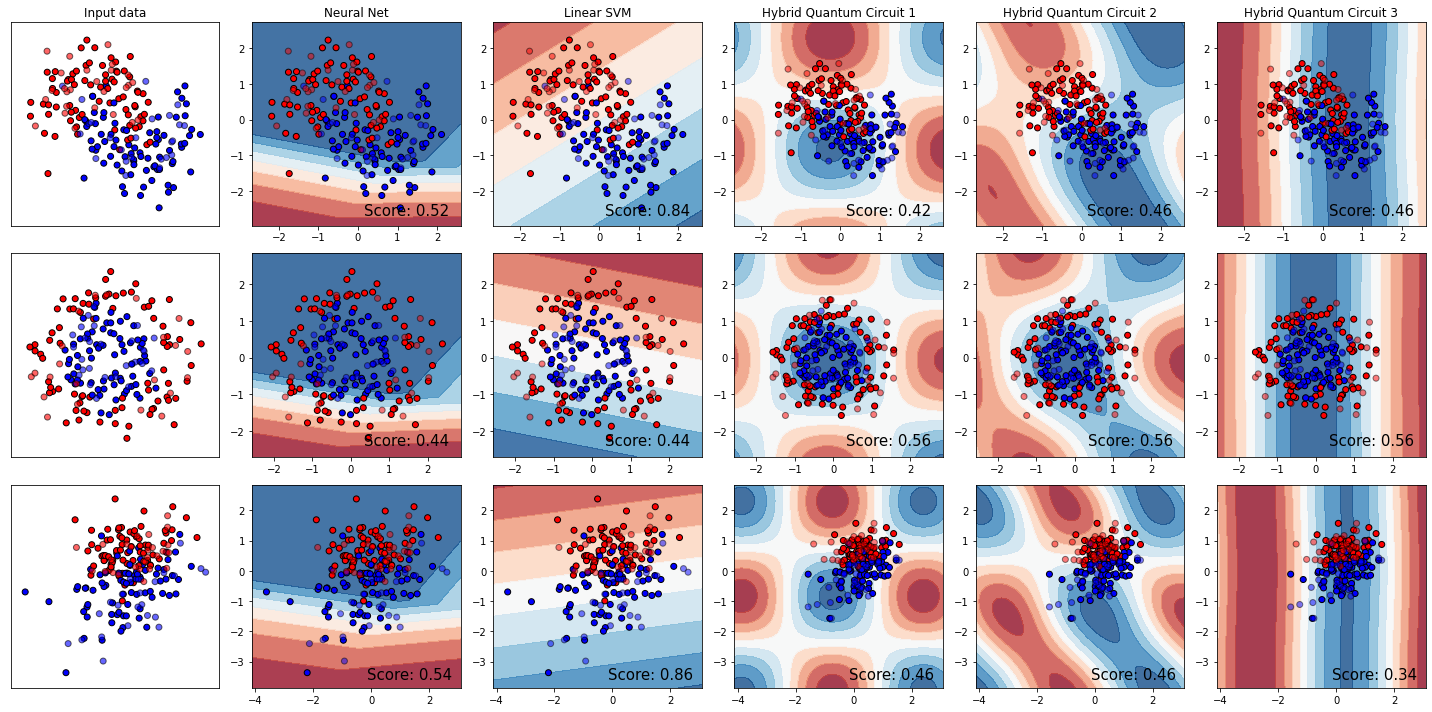

In [4]:
halfPi = pi/2
# h = 0.02  # step size in the mesh
h = 0.03  # step size in the mesh
n_samples = 200

names = [
    "Neural Net",
    "Linear SVM",
    "Hybrid Quantum Circuit 1",
    "Hybrid Quantum Circuit 2",
    "Hybrid Quantum Circuit 3",
]

classifiers = [
  MLPClassifier(hidden_layer_sizes=(2,),random_state=1, max_iter=50, 
                    solver="sgd", nesterovs_momentum=True),
  SVC(kernel="linear", C=0.025),
  [vc_quantum, vc_classifier_1, init_weights_1, circuit_1],
  [vc_quantum, vc_classifier_2, init_weights_2, circuit_2],
  [vc_quantum, vc_classifier_3, init_weights_3, circuit_3],
]

X, y = make_classification(
    n_samples=n_samples,
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(n_samples=n_samples, noise=0.3, random_state=0),
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(20, 10))
# Figure: set white background
figure.patch.set_facecolor('xkcd:white')

i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds

    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=1
    )
    # scale data between -halfPi, halfPi for quantum data
    X_scaled = MinMaxScaler(feature_range=(-halfPi,halfPi), copy=True).fit_transform(X)
    X_train_scaled = MinMaxScaler(feature_range=(-halfPi,halfPi), copy=True).fit_transform(X_train)
    X_test_scaled = MinMaxScaler(feature_range=(-halfPi,halfPi), copy=True).fit_transform(X_test)

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        
        if 'Quantum' in name:
          # Quantum circuit #
          vars, score = clf[0](clf[1], clf[2], X_train_scaled, X_test_scaled, X_scaled, y_train, y_test, y)
          Z = np.array(
            [clf[1](vars, f) for f in np.c_[xx.ravel(), yy.ravel()]]
          )

          # Put the result into a color plot
          Z = Z.reshape(xx.shape)
          ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
          
          # Plot the training points
          ax.scatter(
              X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
          )
          # Plot the testing points
          ax.scatter(
              X_test_scaled[:, 0],
              X_test_scaled[:, 1],
              c=y_test,
              cmap=cm_bright,
              edgecolors="k",
              alpha=0.5,
          )
          
        else:
          # Classical circuits #
          clf.fit(X_train, y_train)
          score = clf.score(X_test, y_test)

          # Plot the decision boundary. For that, we will assign a color to each
          # point in the mesh [x_min, x_max]x[y_min, y_max].
          if hasattr(clf, "decision_function"):
              Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
          else:
              Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

          # Put the result into a color plot
          Z = Z.reshape(xx.shape)
          ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
              
          # Plot the training points
          ax.scatter(
              X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
          )
          # Plot the testing points
          ax.scatter(
              X_test[:, 0],
              X_test[:, 1],
              c=y_test,
              cmap=cm_bright,
              edgecolors="k",
              alpha=0.5,
          )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        # ax.set_xticks(())
        # ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("Score: %.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

In [5]:
for name, clf in zip(names, classifiers):
    if 'Quantum' in name:
      print(name)
      print(clf[3].draw())


Hybrid Quantum Circuit 1
 0: ──H──RY(3.08)──RY(-0.836)──RX(2.85)──RX(0.829)──┤ ⟨Z⟩ 

Hybrid Quantum Circuit 2
 0: ──H──RY(3.08)──RY(-0.748)──RX(0.644)──RZ(-0.576)──RX(2.85)──RY(-0.544)──RX(0.404)──RZ(0.00707)──┤ ⟨Z⟩ 

Hybrid Quantum Circuit 3
 0: ──RY(3.08)──RY(-0.417)──╭C─────────────────────────╭RY(0.0704)──┤ ⟨Z⟩ 
 1: ──RY(2.85)──────────────╰RY(-0.0153)──RY(-0.0145)──╰C───────────┤     

